In [1]:
!pip install --upgrade base58 pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.2 MB/s eta 0:00:00


In [2]:
!pip install qiskit[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 36.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=09f9a62e45009b0f84a22dfe739283b203a02a2f518281d90cb80ed40d654e42
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=240

In [4]:
!pip install qiskit_aer

In [33]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from fractions import Fraction
from collections import Counter
from math import gcd
from functools import reduce
import pandas as pd

# --- Funciones de curva elíptica ---
def add_points(P, Q, A, p):
    if P is None:
        return Q
    if Q is None:
        return P

    x1, y1 = P
    x2, y2 = Q

    if x1 == x2 and y1 != y2:
        return None

    if P == Q:
        if x1 == 0:
            return None
        m = (3 * x1 * x1 + A) * inv_mod(2 * y1, p)
    else:
        if x1 == x2:
            return None
        m = (y2 - y1) * inv_mod(x2 - x1, p)

    m %= p
    x3 = (m * m - x1 - x2) % p
    y3 = (m * (x1 - x3) - y1) % p

    return (x3, y3)



def calcular_orden_Cuantico(A, B, P, p, es_par = False):
  try:
      # --- Parámetros ---
    n_input = 4  # log2(N)
    N = 2 ** n_input
    shots = 2048

    # --- Tabla de puntos y codificación ---
    lista_puntos = []
    R = None

    print(f"\n📌 Curva generada: y² = x³ + {A}x + {B} mod {p}")
    print(f"🔸 Punto generador G = {P}")


    for k in range(1, p**2 + 2):
        R = add_points(R, P, A, p)
        if R is None or R in lista_puntos:
          if es_par	:
            lista_puntos.append((0,0))
          break
        lista_puntos.append(R)
    orden = len(lista_puntos)


    # Extensión de la secuencia periódica hasta N
    lista_extendida = [lista_puntos[i % orden] for i in range(N)]

    # Diccionario punto -> índice
    punto_a_indice = {str(pt): i for i, pt in enumerate(lista_puntos)}

    # Construcción de tabla
    rows = []
    for k in range(N):
        bin_k = format(k, f"0{N.bit_length()-1}b")   # binario con ceros a la izquierda
        punto = lista_extendida[k]                  # kP
        idx = punto_a_indice[str(punto)]            # índice asociado
        bin_idx = format(idx, f"0{orden.bit_length()}b")  # salida en binario

        rows.append({
            "k": k,
            "bin_k (entrada)": bin_k,
            "kP (punto)": str(punto),
            "bin_idx (salida)": bin_idx,
            # Puedes añadir "Puertas aplicadas" si lo defines
        })

    df = pd.DataFrame(rows)
    print("\n")
    print("Tabla de connfiguración del oráculo")
    print(df)

    # --- Circuito cuántico ---
    n_output = orden.bit_length()
    qc = QuantumCircuit(n_input + n_output, n_input)

    # 1. Superposición en registro de entrada
    qc.h(range(n_input))

    # 2. Codificación reversible k·P en segundo registro
    for k in range(N):
        bin_k = format(k, f"0{n_input}b")
        kP = lista_extendida[k]
        if kP is None:
            continue
        idx = punto_a_indice.get(str(kP), None)
        if idx is None:
            continue
        bin_idx = format(idx, f"0{n_output}b")

        for i in range(n_input):
            if bin_k[i] == '0':
                qc.x(i)
        for j in range(n_output):
            if bin_idx[j] == '1':
                qc.mcx(list(range(n_input)), n_input + j)
        for i in range(n_input):
            if bin_k[i] == '0':
                qc.x(i)

    # 3. QFT inversa sobre registro de entrada
    qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))

    # 4. Medición
    qc.measure(range(n_input), range(n_input))


    # --- Simulación ---
    simulator = Aer.get_backend('aer_simulator')
    qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()


    print("\n")
    print("Tabla de resultados cuánticos")
    print(counts)

    # --- Análisis de resultados ---
    def mcm_lista(lista):
        def mcm(a, b):
            return abs(a * b) // gcd(a, b)
        return reduce(mcm, lista) if lista else None

    fracciones_info = []
    for bitstring, freq in counts.items():
        s = int(bitstring.replace(" ", ""), 2)
        if s == 0:
            continue
        frac = Fraction(s, N).limit_denominator(N)
        fracciones_info.append({
            "Medición binaria": bitstring,
            "Decimal": s,
            "Frecuencia": freq,
            "Fracción m/N": f"{s}/{N}",
            "Fracción reducida": f"{frac.numerator}/{frac.denominator}",
            "Posible orden (denominador)": frac.denominator
        })
    orden_estimado = 0
    if fracciones_info:
        df = pd.DataFrame(fracciones_info)
        df = df.sort_values("Frecuencia", ascending=False)
        denominadores = [f["Posible orden (denominador)"] for f in fracciones_info if 1 < f["Posible orden (denominador)"] <= N]
        orden_estimado = mcm_lista(denominadores)
        input = n_input**2
        if not es_par:
          orden_estimado += 1
          input += 1
        print("\n")
        print("Tabla de fracciones continuas")
        print(df.to_string(index=False))
        if orden_estimado == input:
          print ("No se encontró un orden")
          return 0
        print("\n")
        print(f"\n🔎 Orden estimado del punto P: {orden_estimado}")
    else:
        print("⚠️ No se obtuvieron resultados útiles.")
    print("\n")
    return orden_estimado
  except  Exception as e:
    print(e)
    return 0

🚀 Iniciando simulación de curva elíptica ECC...


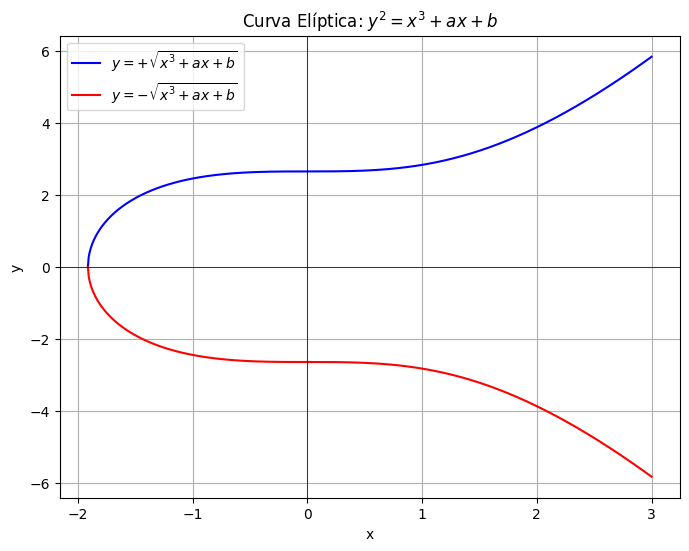


📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (0, 6)


Tabla de connfiguración del oráculo
     k bin_k (entrada) kP (punto) bin_idx (salida)
0    0            0000     (0, 6)                0
1    1            0001     (0, 6)                0
2    2            0010     (0, 6)                0
3    3            0011     (0, 6)                0
4    4            0100     (0, 6)                0
5    5            0101     (0, 6)                0
6    6            0110     (0, 6)                0
7    7            0111     (0, 6)                0
8    8            1000     (0, 6)                0
9    9            1001     (0, 6)                0
10  10            1010     (0, 6)                0
11  11            1011     (0, 6)                0
12  12            1100     (0, 6)                0
13  13            1101     (0, 6)                0
14  14            1110     (0, 6)                0
15  15            1111     (0, 6)                0


Tabla de resultados c

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0000': 2048}
⚠️ No se obtuvieron resultados útiles.



📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (3, 11)


Tabla de connfiguración del oráculo
     k bin_k (entrada) kP (punto) bin_idx (salida)
0    0            0000    (3, 11)              000
1    1            0001    (0, 23)              001
2    2            0010    (13, 0)              010
3    3            0011     (0, 6)              011
4    4            0100    (3, 18)              100
5    5            0101    (3, 11)              000
6    6            0110    (0, 23)              001
7    7            0111    (13, 0)              010
8    8            1000     (0, 6)              011
9    9            1001    (3, 18)              100
10  10            1010    (3, 11)              000
11  11            1011    (0, 23)              001
12  12            1100    (13, 0)              010
13  13            1101     (0, 6)              011
14  14            1110    (3, 18)   

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1111': 9, '0001': 4, '0100': 25, '0111': 106, '0011': 390, '1011': 23, '1101': 378, '1010': 254, '1100': 27, '0110': 208, '1000': 21, '0000': 415, '0010': 19, '1110': 18, '1001': 116, '0101': 35}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            0011        3         390         3/16              3/16                           16
            1101       13         378        13/16             13/16                           16
            1010       10         254        10/16               5/8                            8
            0110        6         208         6/16               3/8                            8
            1001        9         116         9/16              9/16                           16
            0111        7         106         7/16              7/16                           16
            0101        5          35         5/16  

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1010': 125, '0000': 168, '1110': 131, '0110': 129, '1000': 152, '0101': 109, '1001': 157, '1100': 97, '1111': 147, '0001': 149, '0010': 132, '0011': 105, '0111': 148, '1011': 107, '1101': 107, '0100': 85}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1001        9         157         9/16              9/16                           16
            1000        8         152         8/16               1/2                            2
            0001        1         149         1/16              1/16                           16
            0111        7         148         7/16              7/16                           16
            1111       15         147        15/16             15/16                           16
            0010        2         132         2/16               1/8                            8
            1110       14         131      

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0010': 115, '1101': 143, '0011': 121, '0111': 129, '1011': 119, '0100': 121, '0000': 124, '0001': 138, '1111': 125, '1100': 154, '1001': 139, '0101': 136, '1110': 122, '1010': 107, '1000': 140, '0110': 115}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1100       12         154        12/16               3/4                            4
            1101       13         143        13/16             13/16                           16
            1000        8         140         8/16               1/2                            2
            1001        9         139         9/16              9/16                           16
            0001        1         138         1/16              1/16                           16
            0101        5         136         5/16              5/16                           16
            0111        7         129    

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0100': 477, '1000': 512, '1100': 533, '0000': 526}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1100       12         533        12/16               3/4                            4
            1000        8         512         8/16               1/2                            2
            0100        4         477         4/16               1/4                            4



🔎 Orden estimado del punto P: 5



📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (11, 2)


Tabla de connfiguración del oráculo
     k bin_k (entrada) kP (punto) bin_idx (salida)
0    0            0000    (11, 2)             0000
1    1            0001   (12, 16)             0001
2    2            0010   (28, 21)             0010
3    3            0011     (6, 7)             0011
4    4            0100    (13, 0)             0100
5    5            0101    (6, 22)    

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1111': 26, '1101': 98, '1000': 17, '0110': 57, '0111': 251, '0011': 79, '1011': 170, '0000': 227, '0010': 204, '1100': 126, '1110': 198, '1001': 237, '0101': 168, '0100': 122, '0001': 19, '1010': 49}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            0111        7         251         7/16              7/16                           16
            1001        9         237         9/16              9/16                           16
            0010        2         204         2/16               1/8                            8
            1110       14         198        14/16               7/8                            8
            1011       11         170        11/16             11/16                           16
            0101        5         168         5/16              5/16                           16
            1100       12         126        12/

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0000': 489, '0100': 502, '1000': 511, '1100': 546}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1100       12         546        12/16               3/4                            4
            1000        8         511         8/16               1/2                            2
            0100        4         502         4/16               1/4                            4



🔎 Orden estimado del punto P: 5



📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (13, 0)
base is not invertible for the given modulus

📌 Curva generada: y² = x³ + 0x + 7 mod 29
🔸 Punto generador G = (14, 5)


Tabla de connfiguración del oráculo
     k bin_k (entrada) kP (punto) bin_idx (salida)
0    0            0000    (14, 5)             0000
1    1            0001   (26, 26)             0001
2    2            0010   (12, 13)             0010
3    3            001

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1010': 120, '1111': 162, '0100': 111, '1101': 102, '0110': 132, '1000': 173, '1100': 92, '1110': 123, '1001': 147, '0101': 121, '0010': 115, '0000': 162, '1011': 101, '0111': 131, '0011': 106, '0001': 150}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1000        8         173         8/16               1/2                            2
            1111       15         162        15/16             15/16                           16
            0001        1         150         1/16              1/16                           16
            1001        9         147         9/16              9/16                           16
            0110        6         132         6/16               3/8                            8
            0111        7         131         7/16              7/16                           16
            1110       14         123     

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0001': 138, '0100': 99, '1010': 119, '0111': 166, '0011': 93, '1011': 95, '1110': 116, '1111': 161, '0101': 107, '1001': 175, '1100': 109, '0000': 154, '0010': 135, '1000': 158, '0110': 127, '1101': 96}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1001        9         175         9/16              9/16                           16
            0111        7         166         7/16              7/16                           16
            1111       15         161        15/16             15/16                           16
            1000        8         158         8/16               1/2                            2
            0001        1         138         1/16              1/16                           16
            0010        2         135         2/16               1/8                            8
            0110        6         127        

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1111': 104, '1110': 130, '0010': 126, '0000': 133, '0110': 118, '1000': 123, '0101': 131, '1001': 141, '1100': 143, '0111': 116, '0011': 121, '1011': 142, '1101': 144, '0100': 135, '0001': 112, '1010': 129}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1101       13         144        13/16             13/16                           16
            1100       12         143        12/16               3/4                            4
            1011       11         142        11/16             11/16                           16
            1001        9         141         9/16              9/16                           16
            0100        4         135         4/16               1/4                            4
            0101        5         131         5/16              5/16                           16
            1110       14         130    

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1110': 115, '1101': 133, '0100': 122, '1011': 121, '0111': 134, '0011': 129, '0001': 134, '1111': 132, '1010': 116, '1001': 144, '0101': 132, '0000': 107, '0010': 136, '1100': 134, '0110': 120, '1000': 139}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1001        9         144         9/16              9/16                           16
            1000        8         139         8/16               1/2                            2
            0010        2         136         2/16               1/8                            8
            1100       12         134        12/16               3/4                            4
            0111        7         134         7/16              7/16                           16
            0001        1         134         1/16              1/16                           16
            1101       13         133    

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1101': 111, '0000': 158, '0011': 115, '0111': 147, '1011': 109, '1100': 82, '0101': 102, '1001': 130, '0001': 170, '1111': 150, '1110': 127, '1000': 150, '0110': 134, '0010': 146, '0100': 94, '1010': 123}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            0001        1         170         1/16              1/16                           16
            1111       15         150        15/16             15/16                           16
            1000        8         150         8/16               1/2                            2
            0111        7         147         7/16              7/16                           16
            0010        2         146         2/16               1/8                            8
            0110        6         134         6/16               3/8                            8
            1001        9         130      

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'1101': 134, '1010': 113, '0000': 120, '0010': 119, '0111': 145, '0011': 119, '1011': 122, '1001': 125, '0101': 131, '1110': 147, '1100': 133, '1111': 123, '0001': 136, '1000': 129, '0110': 125, '0100': 127}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1110       14         147        14/16               7/8                            8
            0111        7         145         7/16              7/16                           16
            0001        1         136         1/16              1/16                           16
            1101       13         134        13/16             13/16                           16
            1100       12         133        12/16               3/4                            4
            0101        5         131         5/16              5/16                           16
            1000        8         129    

/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))
/tmp/ipython-input-1618258449.py:125: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_input, inverse=True, do_swaps=False), range(n_input))




Tabla de resultados cuánticos
{'0001': 22, '1000': 9, '0110': 46, '1100': 123, '1110': 196, '1001': 254, '0101': 179, '0100': 122, '0000': 237, '0010': 210, '1011': 182, '0111': 222, '0011': 82, '1101': 79, '1111': 29, '1010': 56}


Tabla de fracciones continuas
Medición binaria  Decimal  Frecuencia Fracción m/N Fracción reducida  Posible orden (denominador)
            1001        9         254         9/16              9/16                           16
            0111        7         222         7/16              7/16                           16
            0010        2         210         2/16               1/8                            8
            1110       14         196        14/16               7/8                            8
            1011       11         182        11/16             11/16                           16
            0101        5         179         5/16              5/16                           16
            1100       12         123        12/1

In [34]:
# Sistema híbrido de curva elíptica con ECDH y ECDSA paso a paso

import random
from sympy.ntheory import isprime
from math import gcd
import pandas as pd
import time
import base58
from Crypto.Hash import RIPEMD160
import hashlib
import matplotlib.pyplot as plt
import numpy as np

# ======================
# Etapa 1: Definir curva
# ======================
def generar_curva():
    p = 29
    a = 0
    b = 7
    return p, a, b

# ============================
# Etapa 2: Buscar puntos válidos
# ============================
def puntos_en_curva(p, a, b):
    puntos = []
    for x in range(p):
        rhs = (x**3 + a*x + b) % p
        for y in range(p):
            if (y*y) % p == rhs:
                puntos.append((x, y))
    return puntos

# ============================
# Etapa 3: Sumar puntos y calcular orden
# ============================
def inv_mod(k, p):
    """Inverso modular"""
    return pow(k, -1, p)
def ec_add(P, Q, a, p):
    if P is None: return Q
    if Q is None: return P
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and (y1 + y2) % p == 0:
        return None
    if P == Q:
        if x1 == 0:
            return None
        m = ((3 * x1**2 + a) * inv_mod(2 * y1, p)) % p
    else:
        m = ((y2 - y1) * inv_mod(x2 - x1, p)) % p
    x3 = (m**2 - x1 - x2) % p
    y3 = (m * (x1 - x3) - y1) % p
    return (x3, y3)

def calcular_orden(P, a, p):
    R = P
    for i in range(2, p * 2):
        R = ec_add(R, P, a, p)
        if R is None:
            return i
    return -1

# =====================================
# Etapa 4: Multiplicación escalar (dG)
# =====================================
def multiplicacion_escalar(P, d, a, p):
    Q = None
    for bit in bin(d)[2:]:
        Q = ec_add(Q, Q, a, p)
        if bit == '1':
            Q = ec_add(Q, P, a, p)
    return Q

# =====================================
# Etapa 5: Generar claves y punto G
# =====================================
def seleccionar_punto_generador(p, a, b):
    puntos = puntos_en_curva(p, a, b)
    ordenes = [(pt, calcular_orden_Cuantico(a, b, pt, p, False)) for pt in puntos]
    ordenes = [(pt, o) for pt, o in ordenes if isprime(o) and o >= 3]
    if not ordenes:
        raise RuntimeError("❌ No se encontraron puntos con orden primo suficiente")
    ordenes.sort(key=lambda x: -x[1])
    return ordenes[0], ordenes

# ===============================
# Etapa 6: Simulación ECDSA
# ===============================
def firmar_mensaje(G, d, a, p, orden):
    print("⏳ Iniciando firma de mensaje...")
    h = random.randint(1, orden - 1)
    intentos = 0
    max_intentos = 1000
    while intentos < max_intentos:
        k = random.randint(1, orden - 1)
        R = multiplicacion_escalar(G, k, a, p)
        if R is None:
            intentos += 1
            continue
        r = R[0] % orden
        if r == 0:
            intentos += 1
            continue
        try:
            kinv = inv_mod(k, orden)
            s = (kinv * (h + r * d)) % orden
            if s != 0:
                print(f"✅ Firma generada en {intentos + 1} intentos")
                return (r, s), h
        except ValueError:
            pass
        intentos += 1
    raise RuntimeError("❌ No se pudo generar una firma válida tras múltiples intentos")

def verificar_firma(G, d, r, s, h, a, p, orden):
    w = inv_mod(s, orden)
    u1 = (h * w) % orden
    u2 = (r * w) % orden
    X = ec_add(multiplicacion_escalar(G, u1, a, p), multiplicacion_escalar(multiplicacion_escalar(G, d, a, p), u2, a, p), a, p)
    return X and X[0] % orden == r

# ===============================
# Etapa adicional: codificación y compresión
# ===============================
def codificar_clave_publica(Q):
    qx, qy = Q
    pubkey_bytes = bytes([qx, qy])
    print(f"\n🔐 Q codificada como bytes: {pubkey_bytes.hex()}")
    sha256_hash = hashlib.sha256(pubkey_bytes).digest()
    print(f"🔁 SHA-256(Q): {sha256_hash.hex()}")
    ripemd160 = RIPEMD160.new()
    ripemd160.update(sha256_hash)
    ripemd_hash = ripemd160.digest()
    print(f"🔁 RIPEMD-160(SHA-256(Q)): {ripemd_hash.hex()}")
    prefixed = b'\x00' + ripemd_hash
    checksum = hashlib.sha256(hashlib.sha256(prefixed).digest()).digest()[:4]
    address_bytes = prefixed + checksum
    simulated_address = base58.b58encode(address_bytes).decode()
    print(f"🏁 Dirección simulada estilo Bitcoin: {simulated_address}")
    return simulated_address

def comprimir_clave_publica(Q):
    x, y = Q
    prefix = b'\x02' if y % 2 == 0 else b'\x03'
    compressed = prefix + bytes([x])
    print(f"📦 Clave pública comprimida (SEC): {compressed.hex()}")
    return compressed

def descomprimir_y_verificar(Q, a, b, p):
    x, y = Q
    prefix = b'\x02' if y % 2 == 0 else b'\x03'
    prefix_int = int.from_bytes(prefix, 'big')
    y_parity = 0 if prefix_int == 2 else 1
    rhs = (x**3 + a*x + b) % p
    y_candidates = [y_ for y_ in range(p) if (y_ * y_) % p == rhs and y_ % 2 == y_parity]
    y_recovered = y_candidates[0] if y_candidates else None
    print(f"🔎 Coordenada Y recuperada: {y_recovered}")
    print(f"🔁 Punto descomprimido: ({x}, {y_recovered})")
    coincide = Q == (x, y_recovered)
    print("✅ Punto descomprimido coincide con Q" if coincide else "❌ Punto descomprimido NO coincide con Q")

def graficar_curva(a,b):
    # Rango de valores de x
    x = np.linspace(-3, 3, 1000)

    # Ecuación de la curva: y² = x³ + ax + b
    y2 = x**3 + a*x + b

    # Solo tomamos los valores donde y² >= 0 (para que y sea real)
    valid = y2 >= 0
    x_valid = x[valid]
    y_valid = np.sqrt(y2[valid])

    # Graficamos la curva: parte superior e inferior (±y)
    plt.figure(figsize=(8,6))
    plt.plot(x_valid,  y_valid, 'b', label=r'$y = +\sqrt{x^3 + ax + b}$')
    plt.plot(x_valid, -y_valid, 'r', label=r'$y = -\sqrt{x^3 + ax + b}$')

    # Decoración
    plt.title("Curva Elíptica: $y^2 = x^3 + ax + b$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

# ===============================
# Etapa principal
# ===============================
def main():
    tiempos = {}
    print("🚀 Iniciando simulación de curva elíptica ECC...")

    t0 = time.time()
    p, a, b = generar_curva()
    tiempos['Generar curva'] = time.time() - t0

    graficar_curva(a,b)

    t1 = time.time()
    (G, orden), todos = seleccionar_punto_generador(p, a, b)
    tiempos['Seleccionar generador'] = time.time() - t1

    t2 = time.time()
    #d = random.randint(2, orden - 1)
    d = 2 #Se coloca un parámetro d fijo para obligar al algoritmo a usar el punto (6,7)
    Q = multiplicacion_escalar(G, d, a, p)
    tiempos['Multiplicación escalar'] = time.time() - t2

    print(f"\n📌 Curva generada: y² = x³ + {a}x + {b} mod {p}  |  p primo = {isprime(p)}")
    print(f"🔸 Punto generador G = {G} con orden {orden}")
    print(f"🔑 Clave privada d = {d}")
    print(f"🔓 Clave pública Q = dG = {Q}")

    print("\n📍 Todos los puntos válidos y sus órdenes:")
    df = pd.DataFrame(todos, columns=['Punto', 'Orden'])
    print(df)

    t3 = time.time()
    (r, s), h = firmar_mensaje(G, d, a, p, orden)
    tiempos['Firma ECDSA'] = time.time() - t3
    print(f"\n✍️ Firma generada: r = {r}, s = {s}, hash = {h}")

    t4 = time.time()
    es_valida = verificar_firma(G, d, r, s, h, a, p, orden)
    tiempos['Verificar firma'] = time.time() - t4
    print("✔️ Verificación exitosa" if es_valida else "❌ Verificación fallida")

    codificar_clave_publica(Q)
    comprimir_clave_publica(Q)

    t5 = time.time()
    descomprimir_y_verificar(Q, a, b, p)
    tiempos['Codificación y compresión'] = time.time() - t5

    print("✅ Script finalizado correctamente")
    print("\n⏱️ Resumen de tiempos por etapa:")
    resumen = pd.DataFrame(list(tiempos.items()), columns=['Etapa', 'Tiempo (s)'])
    print(resumen)

if __name__ == "__main__":
    main()
